In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure Kubernetes Learning Path,24.492743,12.246372,2
FSLogix,539.634398,22.484767,24
Search Engine Optimization,576.742639,96.123773,6
Powershell,606.367617,50.530635,12
JavaScript Concepts,663.520415,9.345358,71
Audit Report Tracker (Sharepoint List),798.841522,49.927595,16
Azure Functions + Visual Studio,828.944475,59.210320,14
Email Auth and Security,860.042586,66.157122,13
DNS,966.878254,60.429891,16
OData,989.317393,65.954493,15


# Histogram

38479.91


<Axes: >

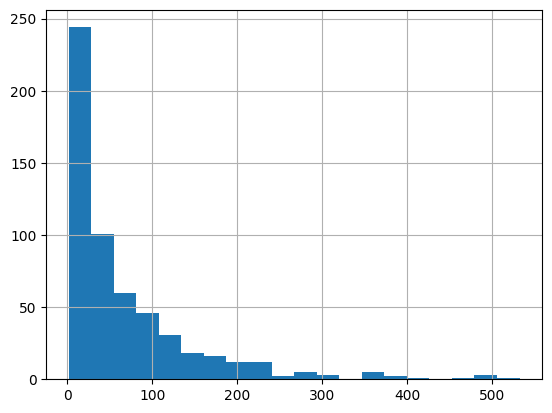

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [13]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Max

In [14]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [15]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [16]:
n=3
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 563


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
192,Azure Kubernetes Learning Path,Dockerfile Example:\nFROM mcr.microsoft.com/do...,184ed4422a0154f25c101abff1d2fd76,-16.313067,-12.246372,16.313067,24.492743,0.078476,2,0,0
383,Azure Kubernetes Learning Path,Docker creates and manages the new volume by r...,59fdab5781ca7e600688a88a3fb9e17d,-8.179677,-12.246372,16.313067,24.492743,0.078476,2,1,0
45,Search Engine Optimization,"Domain Authority (DA), developed by Moz, is a ...",1d9f6283a52192064acd590f8da70bc7,-353.999893,-96.123773,353.999893,576.742639,0.548218,6,0,0
242,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-77.388541,-96.123773,353.999893,576.742639,0.548218,6,1,0
431,Search Engine Optimization,An XML sitemap is a file that lists all the im...,5ee51c940547878d68b1599c861a308d,-48.938643,-96.123773,353.999893,576.742639,0.548218,6,2,0
97,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-235.363044,-106.526325,235.363044,1171.789580,0.372877,11,0,0
292,Vocab,Hieratic\nadjective\nSPA: hi-uh-RAT-ik\nIPA: /...,ca40d5a4cd7caf50cb01f3c6d0964e6d,-222.648673,-106.526325,235.363044,1171.789580,0.372877,11,1,0
477,Vocab,Intercalation\nnoun\nSPA: in-ter-kay-LAY-shun\...,23caa6b2b1c7d643d2da9e49a7b7a430,-205.404414,-106.526325,235.363044,1171.789580,0.372877,11,2,0
118,Powershell,-AllowClobber\nAllows overwriting of existing ...,7714f3ad42cf33e4637786d64df9b836,-195.044416,-50.530635,195.044416,606.367617,0.309075,12,0,0
311,Powershell,cmd /c\nRuns a Command Prompt command from Pow...,779ca7ad539bad6fddbfef21622f1063,-131.936851,-50.530635,195.044416,606.367617,0.309075,12,1,0


In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
192,Azure Kubernetes Learning Path,Dockerfile Example:\nFROM mcr.microsoft.com/do...,184ed4422a0154f25c101abff1d2fd76,-16.313067,-12.246372,16.313067,24.492743,0.078476,2,0,0
383,Azure Kubernetes Learning Path,Docker creates and manages the new volume by r...,59fdab5781ca7e600688a88a3fb9e17d,-8.179677,-12.246372,16.313067,24.492743,0.078476,2,1,0
45,Search Engine Optimization,"Domain Authority (DA), developed by Moz, is a ...",1d9f6283a52192064acd590f8da70bc7,-353.999893,-96.123773,353.999893,576.742639,0.548218,6,0,0
242,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-77.388541,-96.123773,353.999893,576.742639,0.548218,6,1,0
431,Search Engine Optimization,An XML sitemap is a file that lists all the im...,5ee51c940547878d68b1599c861a308d,-48.938643,-96.123773,353.999893,576.742639,0.548218,6,2,0
97,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-235.363044,-106.526325,235.363044,1171.789580,0.372877,11,0,0
292,Vocab,Hieratic\nadjective\nSPA: hi-uh-RAT-ik\nIPA: /...,ca40d5a4cd7caf50cb01f3c6d0964e6d,-222.648673,-106.526325,235.363044,1171.789580,0.372877,11,1,0
477,Vocab,Intercalation\nnoun\nSPA: in-ter-kay-LAY-shun\...,23caa6b2b1c7d643d2da9e49a7b7a430,-205.404414,-106.526325,235.363044,1171.789580,0.372877,11,2,0
118,Powershell,-AllowClobber\nAllows overwriting of existing ...,7714f3ad42cf33e4637786d64df9b836,-195.044416,-50.530635,195.044416,606.367617,0.309075,12,0,0
311,Powershell,cmd /c\nRuns a Command Prompt command from Pow...,779ca7ad539bad6fddbfef21622f1063,-131.936851,-50.530635,195.044416,606.367617,0.309075,12,1,0


In [18]:
existing_cards['age'].mean()

np.float64(-68.34797737164192)